In [1]:
## Cross validation of GSE161529 dataset using saved model from GSE176078 on 14July

In [3]:
import pandas as pd
import joblib

# Load trained model
#model_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_14July.pkl"

model_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/xgb_model_mito_17July.pkl"
xgb_model = joblib.load(model_path)

# Load GSE161529 dataset WITHOUT 'percent.mito'
#data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_complete_features_mito.csv"
#data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_obs_features_total.csv"
#data_path = "/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_obs_16July_cnv_proto.csv"
df_val_clean = pd.read_csv("/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_obs_16July_cnv_proto.csv")


# Define features used in model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]
features = xgb_model.feature_names_in_.tolist()

# Drop missing values and predict
df_val_clean = df_val_clean.dropna(subset=features)
X_val = df_val_clean[features]
df_val_clean["tumor_prob_mito"] = xgb_model.predict_proba(X_val)[:, 1]
df_val_clean["tumor_pred_mito"] = (df_val_clean["tumor_prob_mito"] > 0.5).astype(int)
df_val_clean["tumor_pred_label_mito"] = df_val_clean["tumor_pred_mito"].map({0: "Predicted Normal", 1: "Predicted Tumor"})

# ✅ Data is ready for further analysis in memory
print("✅ Predictions completed and stored in df_val_clean.")


✅ Predictions completed and stored in df_val_clean.


In [4]:
df_val_clean.head(5)

,Unnamed: 0,sample,sample_id,nCount_RNA,percent.mito,pct_counts_ribo,oxphos_score,apoptosis_score,S_score,G2M_score,phase,cnv_reference,cnv_score,proto_oncogenescore,tumor_prob_mito,tumor_pred_mito,tumor_pred_label_mito
0,AAACCTGAGACTAGGC-1-GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,3587.0,0.0,34.011710,0.625094,-0.135342,-0.267442,-0.172494,G1,tumor,0.019013,0.1,0.930495,1,Predicted Tumor
1,AAACCTGAGGACAGAA-1-GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1003.0,0.0,41.375874,0.034769,0.062697,-0.042636,-0.047786,G1,tumor,0.006503,0.1,0.935484,1,Predicted Tumor
2,AAACCTGAGGATGTAT-1-GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,7536.0,0.0,34.262207,0.494331,-0.068065,-0.428295,-0.325175,G1,tumor,0.039193,1.4,0.926934,1,Predicted Tumor
3,AAACCTGCAAGAGGCT-1-GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,10366.0,0.0,27.532318,1.197279,0.049671,-0.451550,-0.168998,G1,tumor,0.060830,0.7,0.998927,1,Predicted Tumor
4,AAACCTGGTAGCTTGT-1-GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,GSM4909253_N-PM0092-Total,1628.0,0.0,29.545454,-0.016629,0.136129,-0.058140,-0.006993,G1,tumor,0.009706,0.7,0.986144,1,Predicted Tumor


In [5]:
# List of features used in the model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]

# Group by predicted tumor class and compute mean
grouped_summary = df_val_clean.groupby("tumor_pred_mito")[features].mean().T
grouped_summary.columns = ["Predicted Normal (0)", "Predicted Tumor (1)"]

# Print results
print("📊 Mean Feature Values by Predicted Tumor Class:")
print(grouped_summary.round(4))

📊 Mean Feature Values by Predicted Tumor Class:
                     Predicted Normal (0)  Predicted Tumor (1)
apoptosis_score                   -0.0201              -0.0033
oxphos_score                       0.1152               0.7831
pct_counts_ribo                   25.1291              23.3719
nCount_RNA                      1043.8868            5560.8896
cnv_score                          0.0092               0.0345
proto_oncogenescore                0.0607               0.4837
S_score                           -0.0429              -0.2449
G2M_score                         -0.0460              -0.2028
percent.mito                       0.0000               0.0000


In [6]:
from scipy.stats import ttest_ind

# Define your features to test
features = [
    "apoptosis_score", "oxphos_score", "pct_counts_ribo", "nCount_RNA",
    "cnv_score", "proto_oncogenescore", "S_score", "G2M_score","percent.mito"
]

# Create groups
group0 = df_val_clean[df_val_clean["tumor_pred_mito"] == 0]
group1 = df_val_clean[df_val_clean["tumor_pred_mito"] == 1]

# Run t-tests and collect results
results = []
for feature in features:
    t_stat, p_val = ttest_ind(group0[feature], group1[feature], equal_var=False)
    results.append({
        "feature": feature,
        "mean_group0": group0[feature].mean(),
        "mean_group1": group1[feature].mean(),
        "t_stat": t_stat,
        "p_value": p_val
    })

# Convert to DataFrame and sort by p-value
t_test_results = pd.DataFrame(results).sort_values("p_value")

# Display results
t_test_results

,feature,mean_group0,mean_group1,t_stat,p_value
1,oxphos_score,0.115224,0.783072,-220.034320,0.000000e+00
3,nCount_RNA,1043.886833,5560.889618,-267.913057,0.000000e+00
5,proto_oncogenescore,0.060653,0.483659,-219.901544,0.000000e+00
4,cnv_score,0.009168,0.034486,-337.885543,0.000000e+00
6,S_score,-0.042895,-0.244860,184.786574,0.000000e+00
7,G2M_score,-0.045950,-0.202790,116.464854,0.000000e+00
2,pct_counts_ribo,25.129095,23.371946,22.955415,3.503343e-115
0,apoptosis_score,-0.020118,-0.003275,-13.772746,3.842562e-43
8,percent.mito,0.000000,0.000000,NaN,NaN


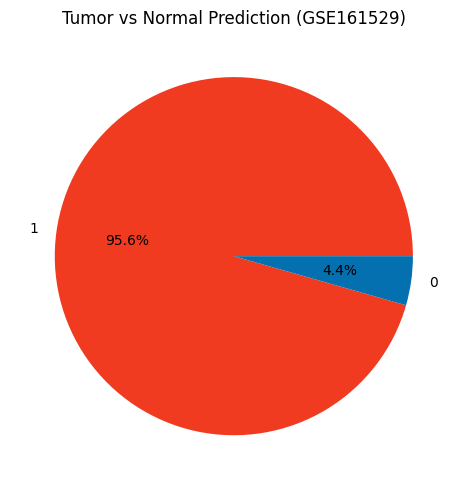

In [7]:
import matplotlib.pyplot as plt

df_val_clean["tumor_pred_mito"].value_counts().plot.pie(
    autopct="%1.1f%%",
    colors=["#f03b20", "#0570b0"],
    figsize=(5, 5)
)
plt.title("Tumor vs Normal Prediction (GSE161529)")
plt.ylabel("")
plt.tight_layout()
plt.show()

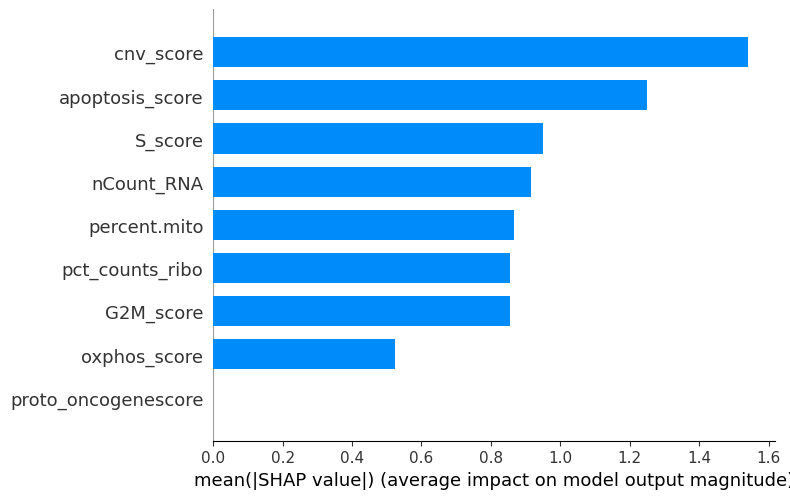

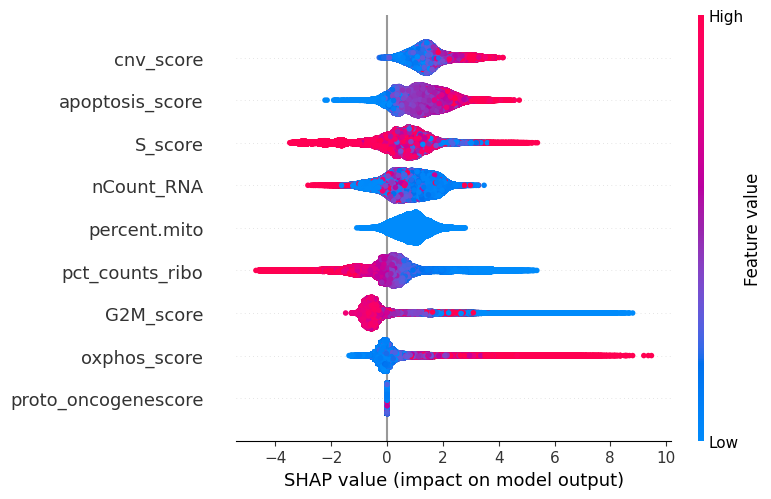

In [8]:
import pandas as pd
import joblib
import shap
import matplotlib.pyplot as plt


# Features used in the model
features = [
    "apoptosis_score", "oxphos_score",
    "pct_counts_ribo", "nCount_RNA", "cnv_score",
    "proto_oncogenescore", "S_score", "G2M_score", "percent.mito"
]
df_val_clean = df_val_clean.dropna(subset=features)
X_val = df_val_clean[features]

# Use TreeExplainer instead of the default (which tries to load GPU deps)
explainer = shap.TreeExplainer(xgb_model)
shap_values = explainer.shap_values(X_val)

# Bar summary plot
shap.summary_plot(shap_values, X_val, plot_type="bar")

# Beeswarm summary plot
shap.summary_plot(shap_values, X_val)

In [9]:
### Saved this csv on 18 July which will be used for oncogene analysis in VS code
df_val_clean.to_csv("/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_predictions_17July_revised_cnv.csv", index=True)

In [10]:
##df_val_clean.to_csv("/content/drive/MyDrive/Capstone (Haider, Rajeev)/ghost-cell-busters/GSE161529_predictions_16July_revised_cnv.csv", index=True)